# Fractional Pseudorandom Generators and Fourier Tails

**Paper**: Chattopadhyay, Hatami, Lovett, Tal. [Pseudorandom Generators from the Second Fourier Level and Applications to AC0 with Parity Gates](https://doi.org/10.4230/LIPIcs.ITCS.2019.22). *ITCS 2019*.

---

A **pseudorandom generator** (PRG) produces samples that "fool" a function class $\mathcal{F}$: no function in $\mathcal{F}$ can distinguish the PRG's output from truly uniform random bits.

This paper introduces a key intermediate object: the **fractional PRG**. Instead of producing samples on the Boolean hypercube $\{-1,+1\}^n$ (the vertices of the cube), a fractional PRG produces samples **inside** the cube $[-1,1]^n$. The function $f$ is then evaluated via its **multilinear extension** $\tilde{f}$, which smoothly interpolates between the vertices.

The main insight: if a function class has bounded **second-level Fourier tails** ($L_{1,2}$), then a fractional PRG with few random bits suffices to fool it.

### What this notebook shows

1. The multilinear extension: how $f$ extends from vertices to the interior of the cube
2. Fractional PRG samples vs hypercube samples
3. Fourier tails $L_{1,k}$ across function families
4. Why bounded $L_{1,2}$ makes fractional PRGs work

In [1]:
!pip install --upgrade boofun -q

import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis.gaussian import multilinear_extension
from boofun.analysis.fourier import fourier_level_lp_norm, fourier_tail_profile

np.random.seed(42)
print(f"boofun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


boofun version: 1.1.1


## 1. The Multilinear Extension

Every Boolean function $f: \{-1,+1\}^n \to \{-1,+1\}$ has a unique **multilinear extension**:

$$\tilde{f}(x) = \sum_S \hat{f}(S) \prod_{i \in S} x_i$$

This polynomial agrees with $f$ at the vertices of $\{-1,+1\}^n$ and extends smoothly to all of $[-1,1]^n$.

A crucial property: $\tilde{f}(\mathbf{0}) = \hat{f}(\emptyset) = \mathbb{E}[f]$. The origin gives the expectation.

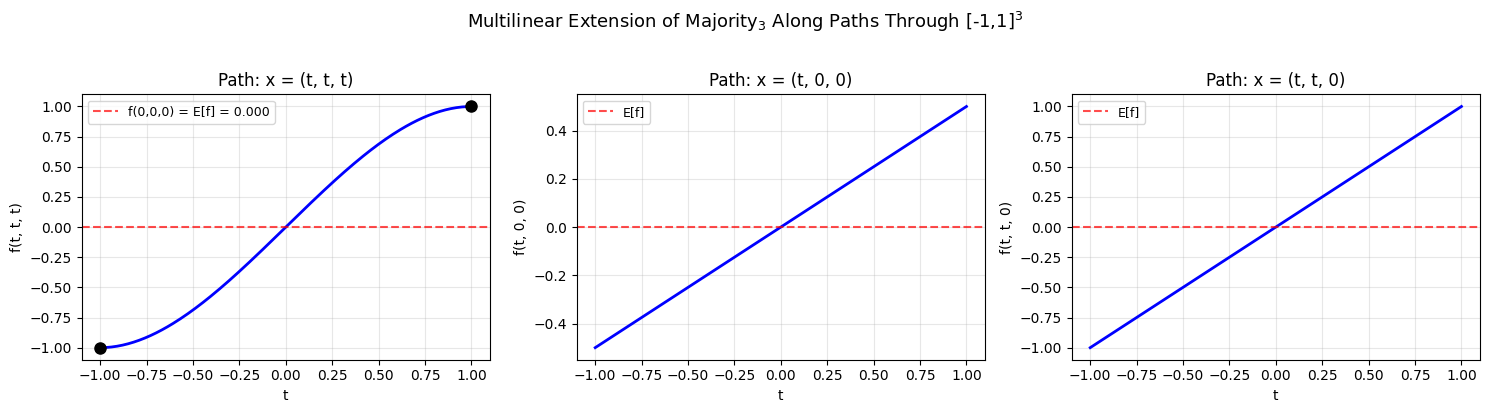

At the origin: f(0,0,0) = 0.0000 = E[f] (Fourier coeff on empty set)
At vertex (+1,+1,+1): f = 1.0000 (Boolean value)
At vertex (-1,-1,-1): f = -1.0000 (Boolean value)
In the interior, the extension interpolates smoothly.


In [2]:
# Visualize the multilinear extension along a path from origin to a vertex
f = bf.majority(3)
p = multilinear_extension(f)
fourier = f.fourier()

# Path: origin (0,0,0) -> vertex (1,1,1), parameterized by t in [0,1]
# x(t) = (t, t, t)
t_vals = np.linspace(-1, 1, 200)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Path 1: all coordinates equal: x = (t, t, t)
y1 = [p(np.array([t, t, t])) for t in t_vals]
axes[0].plot(t_vals, y1, 'b-', linewidth=2)
axes[0].axhline(y=p(np.array([0, 0, 0])), color='red', linestyle='--', alpha=0.7,
               label=f'f(0,0,0) = E[f] = {p(np.array([0,0,0])):.3f}')
for v in [-1, 1]:
    axes[0].plot(v, p(np.array([v, v, v])), 'ko', markersize=8)
axes[0].set_xlabel('t')
axes[0].set_ylabel('f(t, t, t)')
axes[0].set_title('Path: x = (t, t, t)')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Path 2: one coordinate varies, others fixed at 0: x = (t, 0, 0)
y2 = [p(np.array([t, 0, 0])) for t in t_vals]
axes[1].plot(t_vals, y2, 'b-', linewidth=2)
axes[1].axhline(y=p(np.array([0, 0, 0])), color='red', linestyle='--', alpha=0.7,
               label='E[f]')
axes[1].set_xlabel('t')
axes[1].set_ylabel('f(t, 0, 0)')
axes[1].set_title('Path: x = (t, 0, 0)')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Path 3: two coordinates vary, one fixed: x = (t, t, 0)
y3 = [p(np.array([t, t, 0])) for t in t_vals]
axes[2].plot(t_vals, y3, 'b-', linewidth=2)
axes[2].axhline(y=p(np.array([0, 0, 0])), color='red', linestyle='--', alpha=0.7,
               label='E[f]')
axes[2].set_xlabel('t')
axes[2].set_ylabel('f(t, t, 0)')
axes[2].set_title('Path: x = (t, t, 0)')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Multilinear Extension of Majority$_3$ Along Paths Through [-1,1]$^3$',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f"At the origin: f(0,0,0) = {p(np.array([0,0,0])):.4f} = E[f] (Fourier coeff on empty set)")
print(f"At vertex (+1,+1,+1): f = {p(np.array([1,1,1])):.4f} (Boolean value)")
print(f"At vertex (-1,-1,-1): f = {p(np.array([-1,-1,-1])):.4f} (Boolean value)")
print(f"In the interior, the extension interpolates smoothly.")

## 2. Fractional PRG: Sampling Inside the Cube

A **fractional PRG** produces $X \in [-1,1]^n$ such that $|\mathbb{E}[\tilde{f}(X)] - \tilde{f}(\mathbf{0})| \leq \varepsilon$.

The paper's construction (Theorem 9): take a multivariate Gaussian $Z$ with small variance per coordinate and small covariances, then truncate to $[-1,1]^n$.

The key: interior samples are "closer to the origin" where $\tilde{f} \approx E[f]$, so the expectation is easy to preserve.

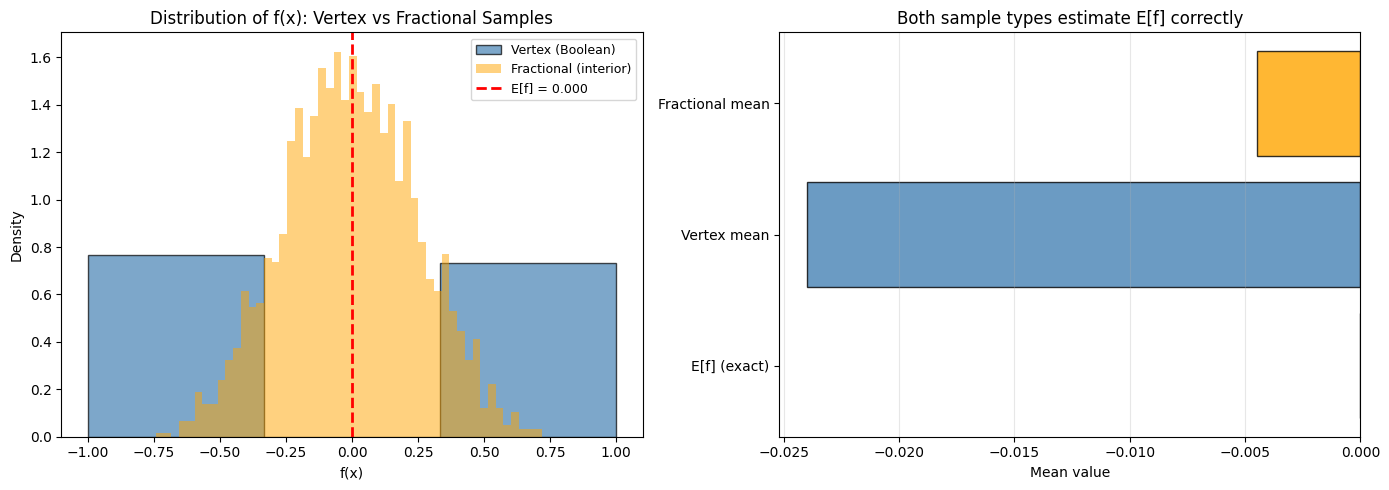

Exact E[f] = f(0) = 0.0000
Vertex mean:     -0.0240  (error: 0.0240)
Fractional mean: -0.0045  (error: 0.0045)

The fractional PRG concentrates near E[f] with much less variance.
Vertex std: 0.9997, Fractional std: 0.2485


In [3]:
# Compare: vertex samples vs fractional (interior) samples
n = 5
f = bf.majority(n)
p_ext = multilinear_extension(f)

n_samples = 2000
exact_mean = p_ext(np.zeros(n))  # f(0) = E[f]

# Vertex samples: uniform on {-1,+1}^n
vertex_vals = []
for _ in range(n_samples):
    x = 2 * np.random.randint(0, 2, size=n) - 1  # uniform {-1,+1}
    vertex_vals.append(p_ext(x.astype(float)))

# Fractional samples: truncated Gaussians (paper's construction)
# Small variance per coordinate, as in Theorem 9
sigma_frac = 0.3  # controls how "spread" the fractional samples are
frac_vals = []
for _ in range(n_samples):
    z = np.random.randn(n) * sigma_frac
    x = np.clip(z, -1, 1)  # truncate to [-1,1]
    frac_vals.append(p_ext(x))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograms
axes[0].hist(vertex_vals, bins=3, density=True, alpha=0.7, color='steelblue',
            edgecolor='black', label='Vertex (Boolean)')
axes[0].hist(frac_vals, bins=50, density=True, alpha=0.5, color='orange',
            label='Fractional (interior)')
axes[0].axvline(x=exact_mean, color='red', linestyle='--', linewidth=2,
               label=f'E[f] = {exact_mean:.3f}')
axes[0].set_xlabel('f(x)')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of f(x): Vertex vs Fractional Samples')
axes[0].legend(fontsize=9)

# Means comparison
vertex_mean = np.mean(vertex_vals)
frac_mean = np.mean(frac_vals)
labels = ['E[f] (exact)', 'Vertex mean', 'Fractional mean']
values = [exact_mean, vertex_mean, frac_mean]
colors = ['red', 'steelblue', 'orange']
axes[1].barh(labels, values, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Mean value')
axes[1].set_title('Both sample types estimate E[f] correctly')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"Exact E[f] = f(0) = {exact_mean:.4f}")
print(f"Vertex mean:     {vertex_mean:.4f}  (error: {abs(vertex_mean - exact_mean):.4f})")
print(f"Fractional mean: {frac_mean:.4f}  (error: {abs(frac_mean - exact_mean):.4f})")
print(f"\nThe fractional PRG concentrates near E[f] with much less variance.")
print(f"Vertex std: {np.std(vertex_vals):.4f}, Fractional std: {np.std(frac_vals):.4f}")

## 3. Fourier Tails: $L_{1,k}$

The paper's PRG construction requires **bounded Fourier tails**. The level-$k$ Fourier tail is:

$$L_{1,k}(f) = \sum_{|S|=k} |\hat{f}(S)|$$

This is the $\ell_1$ norm of Fourier coefficients at degree $k$ (not the $\ell_2$ weight $W^k = \sum |\hat{f}(S)|^2$ that Parseval uses).

The main result (Theorem 2): if $L_{1,2}(\mathcal{F}) \leq t$ for a function class $\mathcal{F}$, then a PRG with seed length $\mathrm{poly}(t, \log n, 1/\varepsilon)$ exists.

In [4]:
# fourier_level_lp_norm(f, k, p=1) computes L_{1,k}(f) = sum_{|S|=k} |f_hat(S)|
# This is now a library function in boofun.analysis.fourier

# Compare L1,k across function families
functions = {
    "Majority_5": bf.majority(5),
    "Majority_7": bf.majority(7),
    "AND_5": bf.AND(5),
    "Parity_5": bf.parity(5),
    "Tribes(2,6)": bf.tribes(2, 6),
    "Dictator_5": bf.dictator(5, 0),
}

print("Fourier Tails L_{1,k}(f) = sum_{|S|=k} |f_hat(S)|")
print("(Paper's Theorem 2 requires bounded L_{1,2})")
print()
header = "{:<16}".format("Function")
for k in range(6):
    header += "{:>10}".format(f"L_{{1,{k}}}")
print(header)
print("-" * 76)

for name, f in functions.items():
    n = f.n_vars
    row = "{:<16}".format(name)
    for k in range(6):
        if k <= n:
            val = fourier_level_lp_norm(f, k)
            row += "{:>10.4f}".format(val)
        else:
            row += "{:>10}".format("-")
    print(row)

print()
print("Key observations:")
print("  Parity: L_{1,n} = 1 (all weight at top degree), L_{1,k<n} = 0")
print("  Dictator: L_{1,1} = 1 (single variable), L_{1,k>1} = 0")
print("  Majority: moderate tails at all levels")
print("  AND: L_{1,0} = large (heavy mean), tails at all levels")

Fourier Tails L_{1,k}(f) = sum_{|S|=k} |f_hat(S)|
(Paper's Theorem 2 requires bounded L_{1,2})

Function           L_{1,0}   L_{1,1}   L_{1,2}   L_{1,3}   L_{1,4}   L_{1,5}
----------------------------------------------------------------------------
Majority_5          0.0000    1.8750    0.0000    1.2500    0.0000    0.3750
Majority_7          0.0000    2.1875    0.0000    2.1875    0.0000    1.3125
AND_5               0.9375    0.3125    0.6250    0.6250    0.3125    0.0625
Parity_5            0.0000    0.0000    0.0000    0.0000    0.0000    1.0000
Tribes(2,6)         0.1562    1.6875    1.9688    1.3750    0.6562    0.1875
Dictator_5          0.0000    1.0000    0.0000    0.0000    0.0000    0.0000

Key observations:
  Parity: L_{1,n} = 1 (all weight at top degree), L_{1,k<n} = 0
  Dictator: L_{1,1} = 1 (single variable), L_{1,k>1} = 0
  Majority: moderate tails at all levels
  AND: L_{1,0} = large (heavy mean), tails at all levels


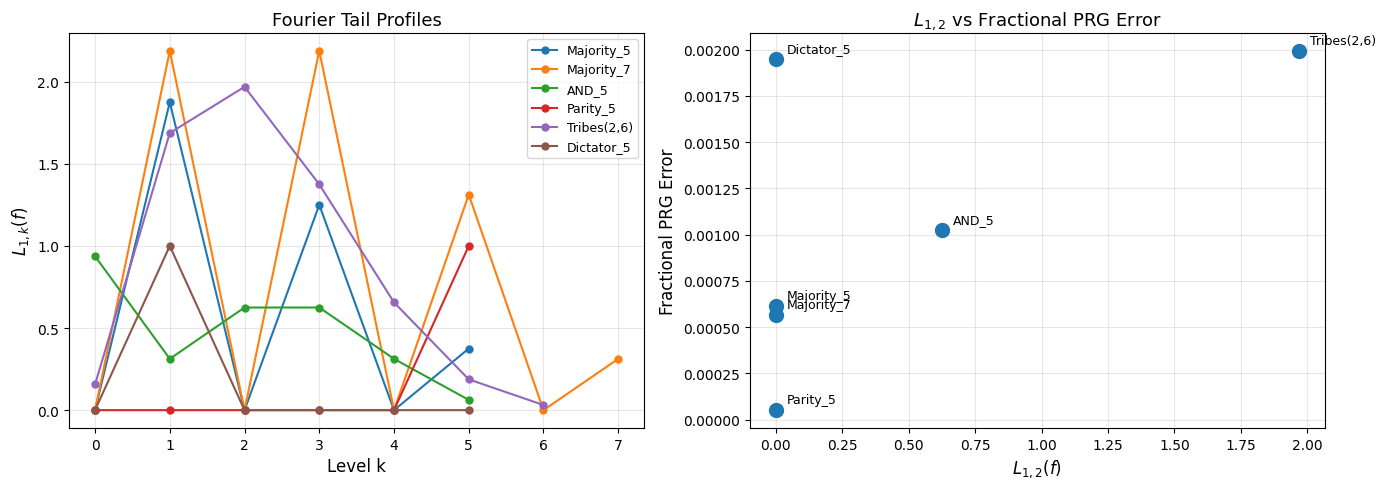

Functions with small L_{1,2} have small fractional PRG error.
This is the mechanism behind the paper's Theorem 2.


In [5]:
# Visualize: L_{1,2} determines foolability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: L1,k profile for different functions
ax = axes[0]
for name, f in functions.items():
    n = f.n_vars
    ks = list(range(n + 1))
    L1_vals = [fourier_level_lp_norm(f, k) for k in ks]
    ax.plot(ks, L1_vals, 'o-', label=name, linewidth=1.5, markersize=5)

ax.set_xlabel('Level k', fontsize=12)
ax.set_ylabel('$L_{1,k}(f)$', fontsize=12)
ax.set_title('Fourier Tail Profiles', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: L_{1,2} vs foolability (fractional PRG error)
ax = axes[1]
l12_values = []
frac_errors = []
names_list = []

for name, f in functions.items():
    n_f = f.n_vars
    p_ext = multilinear_extension(f)
    exact = p_ext(np.zeros(n_f))
    l12 = fourier_level_lp_norm(f, 2)

    # Fractional PRG error: |E[f(X_frac)] - E[f]|
    sigma_frac = 0.3
    frac_sum = 0.0
    for _ in range(3000):
        z = np.clip(np.random.randn(n_f) * sigma_frac, -1, 1)
        frac_sum += p_ext(z)
    frac_mean = frac_sum / 3000
    error = abs(frac_mean - exact)

    l12_values.append(l12)
    frac_errors.append(error)
    names_list.append(name)

ax.scatter(l12_values, frac_errors, s=100, zorder=5)
for i, name in enumerate(names_list):
    ax.annotate(name, (l12_values[i], frac_errors[i]),
               textcoords='offset points', xytext=(8, 5), fontsize=9)
ax.set_xlabel('$L_{1,2}(f)$', fontsize=12)
ax.set_ylabel('Fractional PRG Error', fontsize=12)
ax.set_title('$L_{1,2}$ vs Fractional PRG Error', fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Functions with small L_{1,2} have small fractional PRG error.")
print("This is the mechanism behind the paper's Theorem 2.")

## 4. Theorem 5: First-Level Bound for $\mathbb{F}_2$-Polynomials

As a stepping stone toward their main conjecture, the paper proves:

**Theorem 5**: For $f(x) = (-1)^{p(x)}$ where $p$ is a degree-$d$ polynomial over $\mathbb{F}_2$:

$$L_{1,1}(f) = \sum_i |\hat{f}(\{i\})| \leq 4^d$$

We can verify this numerically. An $\mathbb{F}_2$-polynomial of degree $d$ is a function $(-1)^{p(x)}$ where $p$ is a sum of monomials over GF(2).

In [6]:
def create_f2_polynomial(n, monomials):
    """Create f(x) = (-1)^{p(x)} where p = sum of monomials over F2.
    Each monomial is a set of variable indices."""
    def truth_table_entry(idx):
        bits = [(idx >> j) & 1 for j in range(n)]
        p_val = 0
        for mon in monomials:
            prod = 1
            for i in mon:
                prod *= bits[i]
            p_val ^= prod  # XOR (addition in F2)
        return 0 if p_val == 0 else 1  # f = (-1)^p: 0 -> +1, 1 -> -1
    tt = [truth_table_entry(idx) for idx in range(2**n)]
    return bf.create(tt)

# Test Theorem 5: L_{1,1} <= 4^d for degree-d F2-polynomials
print("Verifying Theorem 5: L_{1,1}(f) <= 4^d for F2-polynomials")
print()
print("{:<40} {:>6} {:>10} {:>10} {:>8}".format(
    "Polynomial p(x)", "deg", "L_{1,1}", "4^d", "OK?"))
print("-" * 76)

# Degree 1: linear polynomials
f = create_f2_polynomial(5, [{0}])  # p(x) = x_0
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0", 1, l11, 4, l11 <= 4))

f = create_f2_polynomial(5, [{0}, {1}, {2}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0 + x_1 + x_2", 1, l11, 4, l11 <= 4))

# Degree 2: quadratic polynomials
f = create_f2_polynomial(5, [{0, 1}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0*x_1", 2, l11, 16, l11 <= 16))

f = create_f2_polynomial(5, [{0, 1}, {2, 3}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0*x_1 + x_2*x_3", 2, l11, 16, l11 <= 16))

f = create_f2_polynomial(6, [{0, 1}, {2, 3}, {4, 5}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0*x_1 + x_2*x_3 + x_4*x_5", 2, l11, 16, l11 <= 16))

# Degree 3
f = create_f2_polynomial(5, [{0, 1, 2}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0*x_1*x_2", 3, l11, 64, l11 <= 64))

f = create_f2_polynomial(6, [{0, 1, 2}, {3, 4, 5}])
l11 = fourier_level_lp_norm(f, 1)
print("{:<40} {:>6} {:>10.4f} {:>10} {:>8}".format("x_0*x_1*x_2 + x_3*x_4*x_5", 3, l11, 64, l11 <= 64))

print()
print("All bounds hold: L_{1,1} <= 4^d confirmed.")

Verifying Theorem 5: L_{1,1}(f) <= 4^d for F2-polynomials

Polynomial p(x)                             deg    L_{1,1}        4^d      OK?
----------------------------------------------------------------------------
x_0                                           1     1.0000          4        1
x_0 + x_1 + x_2                               1     0.0000          4        1
x_0*x_1                                       2     1.0000         16        1
x_0*x_1 + x_2*x_3                             2     1.0000         16        1
x_0*x_1 + x_2*x_3 + x_4*x_5                   2     0.7500         16        1
x_0*x_1*x_2                                   3     0.7500         64        1
x_0*x_1*x_2 + x_3*x_4*x_5                     3     1.1250         64        1

All bounds hold: L_{1,1} <= 4^d confirmed.


## 5. The Open Problem: Conjecture 3

The paper conjectures that for degree-$d$ $\mathbb{F}_2$-polynomials:

$$L_{1,2}(f) = \sum_{i < j} |\hat{f}(\{i,j\})| = O(d^2)$$

If true, this would give PRGs for AC$^0[\oplus]$ -- a major open problem in complexity theory.

We can compute $L_{1,2}$ for small examples to see how it behaves.

In [7]:
# Explore Conjecture 3: L_{1,2} vs d^2 for F2-polynomials
print("Conjecture 3: L_{1,2}(f) = O(d^2) for degree-d F2-polynomials")
print()
print("{:<44} {:>6} {:>10} {:>10}".format(
    "Polynomial p(x)", "deg", "L_{1,2}", "d^2"))
print("-" * 72)

examples = [
    ("x_0", 5, [{0}], 1),
    ("x_0 + x_1 + x_2", 5, [{0}, {1}, {2}], 1),
    ("x_0*x_1", 5, [{0, 1}], 2),
    ("x_0*x_1 + x_2*x_3", 5, [{0, 1}, {2, 3}], 2),
    ("x_0*x_1 + x_2*x_3 + x_0", 5, [{0, 1}, {2, 3}, {0}], 2),
    ("x_0*x_1*x_2", 5, [{0, 1, 2}], 3),
    ("x_0*x_1*x_2 + x_3*x_4", 6, [{0, 1, 2}, {3, 4}], 3),
    ("x_0*x_1*x_2 + x_3*x_4*x_5", 6, [{0, 1, 2}, {3, 4, 5}], 3),
]

for name, n, monomials, d in examples:
    f = create_f2_polynomial(n, monomials)
    l12 = fourier_level_lp_norm(f, 2)
    print("{:<44} {:>6} {:>10.4f} {:>10}".format(name, d, l12, d**2))

print()
print("In all small examples, L_{1,2} << d^2.")
print("The conjecture remains open for general polynomials of degree d = omega(1).")

Conjecture 3: L_{1,2}(f) = O(d^2) for degree-d F2-polynomials

Polynomial p(x)                                 deg    L_{1,2}        d^2
------------------------------------------------------------------------
x_0                                               1     0.0000          1
x_0 + x_1 + x_2                                   1     0.0000          1
x_0*x_1                                           2     0.5000          4
x_0*x_1 + x_2*x_3                                 2     1.5000          4
x_0*x_1 + x_2*x_3 + x_0                           2     1.5000          4
x_0*x_1*x_2                                       3     0.7500          9
x_0*x_1*x_2 + x_3*x_4                             3     1.5000          9
x_0*x_1*x_2 + x_3*x_4*x_5                         3     1.6875          9

In all small examples, L_{1,2} << d^2.
The conjecture remains open for general polynomials of degree d = omega(1).


## Summary

| Concept | Definition | Role in PRG Construction |
|---------|-----------|-------------------------|
| **Multilinear extension** $\tilde{f}$ | Unique multilinear polynomial agreeing with $f$ on $\{-1,+1\}^n$ | Extends $f$ to the cube interior |
| **Fractional PRG** | $X \in [-1,1]^n$ with $\|\mathbb{E}[\tilde{f}(X)] - \tilde{f}(0)\| \leq \varepsilon$ | Intermediate construction, easier than full PRG |
| **Fourier tail** $L_{1,k}$ | $\sum_{|S|=k} |\hat{f}(S)|$ | Bounded $L_{1,2}$ suffices for PRG (Theorem 2) |
| **Polarizing walk** | Iteratively rounds fractional coordinates to $\pm 1$ | Converts fractional PRG to standard PRG |
| **Conjecture 3** | $L_{1,2}(\text{deg-}d\ \mathbb{F}_2\text{-poly}) = O(d^2)$ | Would give PRGs for AC$^0[\oplus]$ |

### boofun API used

```python
from boofun.analysis.gaussian import multilinear_extension

p = multilinear_extension(f)   # p: R^n -> R
p(np.zeros(n))                 # = E[f] (origin = expectation)
p(np.array([0.3, -0.5, 0.1])) # evaluate at interior point

fourier = f.fourier()          # Fourier coefficients
# L_{1,k} = sum |f_hat(S)| for |S|=k (compute from coefficients)
```

### Reference

Chattopadhyay, Hatami, Lovett, Tal. [Pseudorandom Generators from the Second Fourier Level and Applications to AC0 with Parity Gates](https://doi.org/10.4230/LIPIcs.ITCS.2019.22). *ITCS 2019*.

---

*This notebook explores the fractional PRG framework using the `boofun` library.*